## Import des bibliothèques

In [29]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import json
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import (
    DatasetDict,
    Value,
    load_dataset,
)
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_recall_fscore_support,
)
from tabulate import tabulate
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

## Création d'une classe `DataCollator`

In [30]:
class DataCollator:
    """
    Regroupe et organise les exemples en batchs pour le fine-tuning.

    Cette classe :
    - applique un padding dynamique des séquences en fonction du batch,
    - prépare les tenseurs nécessaires (input_ids, attention_mask, labels),
    - retourne un dictionnaire prêt à être passé au modèle Hugging Face.
    """

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, batch, max_length=256, padding="longest", return_tensors="pt"
    ) -> dict[str, torch.Tensor]:
        """
        Prépare un batch de données pour le modèle.

        Applique un padding dynamique via `tokenizer.pad` et retourne
        les tenseurs nécessaires : input_ids, attention_mask et labels.
        """
        return self.tokenizer.pad(
            batch,
            padding=padding,
            max_length=max_length,
            return_tensors=return_tensors,
        )

## Création d'une classe `LLMFineTuner`

In [31]:
class LLMFineTuner:
    """
    Pipeline de fine-tuning pour la classification de sentiments avec des
    modèles Transformers (ex. DistilBERT, RoBERTa).
    """

    # =========================
    # 1. INITIALISATION
    # =========================

    def __init__(
        self,
        dataset="scikit-learn/imdb",
        model_cls=DistilBertForSequenceClassification,
        num_labels=2,  # "negative" (0) et "positive" (1)
        pretrained_model_name_or_path="distilbert-base-uncased",
        tokenizer_cls=DistilBertTokenizer,
        seed=42,
    ):
        """
        Initialise la classe LLMFineTuner et prépare l'environnement de
        travail.

        Cette méthode définit les attributs essentiels pour le fine-tuning :
        - le jeu de données (nom ou objet Hugging Face),
        - les classes nécessaires au modèle et au tokenizer,
        - le nombre de labels (par défaut 2 pour une classification binaire),
        - le chemin ou nom du modèle pré-entraîné,
        - le device d'exécution (GPU si disponible, sinon CPU).

        Args:
            dataset (str ou Dataset, optionnel) :
                Nom du dataset Hugging Face (ex. "scikit-learn/imdb") ou dataset
                  déjà chargé.
            model_cls (nn.Module, optionnel) :
                Classe du modèle de classification à utiliser (par défaut
                  DistilBERT).
            num_labels (int, optionnel) :
                Nombre de classes de sortie du modèle (par défaut 2 : "negative"
                  et "positive").
            pretrained_model_name_or_path (str, optionnel) :
                Nom ou chemin vers le modèle pré-entraîné à charger.
            tokenizer_cls (transformers.PreTrainedTokenizer, optionnel) :
                Classe du tokenizer associée au modèle (par défaut DistilBERT
                  tokenizer).
            seed (int, optionnel) :
                Graine pour la reproductibilité des expériences.

        Attributs principaux initialisés :
            - self.dataset : référence vers le dataset choisi
            - self.train_set / self.valid_set : splits entraînement et validation
                (None par défaut)
            - self.data_collator, self.train_loader, self.valid_loader : objets
                DataLoader (None par défaut)
            - self.tokenizer_cls, self.model_cls : classes pour instancier le
                tokenizer et le modèle
            - self.num_labels, self.pretrained_model_name_or_path : configuration
                du modèle
            - self.device : "cuda" si GPU disponible, sinon "cpu"
            - self.seed : graine pour la reproductibilité des expériences
        """
        # Données
        self.dataset = dataset
        self.train_set = None
        self.valid_set = None

        # DataLoader
        self.data_collator = None
        self.train_loader = None
        self.valid_loader = None

        # Modèle et tokenisation
        self.tokenizer_cls = tokenizer_cls
        self.model_cls = model_cls
        self.num_labels = num_labels
        self.pretrained_model_name_or_path = pretrained_model_name_or_path

        # Environnement
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.seed = seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        set_seed(seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # =========================
    # 2. JEU DE DONNEES & TOKENIZER
    # =========================
    def set_dataset(self, verbose=False) -> None:
        """
        Charge et prépare le jeu de données pour l'entraînement et
        l'évaluation.

        Cette méthode :
          - charge le dataset défini dans l'attribut `self.dataset`,
          - renomme les colonnes principales pour garantir la cohérence
            ("review" pour le texte et "sentiment" pour les labels),
          - normalise les labels en entiers 0 (négatif) et 1 (positif),
          - s'assure que la colonne "sentiment" est bien de type `int64`.

        Le traitement s'adapte automatiquement selon le format du dataset :
          - si les labels sont des chaînes de caractères (ex. IMDB : "negative"/"positive"),
            ils sont convertis en entiers,
          - si les labels sont déjà numériques (ex. RottenTomatoes), seul le cast est appliqué.

        Args:
            verbose (bool, optionnel) :
                Si True, affiche un résumé du dataset chargé et normalisé,
                incluant sa taille et sa structure.

        Effets de bord :
            - Met à jour l'attribut `self.dataset` avec un objet DatasetDict
              compatible avec les étapes suivantes du pipeline.
        """
        self.dataset = load_dataset(self.dataset)

        # Récupération des colonnes
        cols = self.dataset["train"].column_names

        # Uniformisation des colonnes
        if "review" not in cols:
            self.dataset = self.dataset.rename_column(cols[0], "review")
        if "sentiment" not in cols:
            self.dataset = self.dataset.rename_column(cols[1], "sentiment")

        # Normaliser les labels en entiers 0/1
        example_val = self.dataset["train"][0]["sentiment"]

        if isinstance(example_val, str):  # IMDB

            def map_labels(example):
                example["sentiment"] = (
                    0 if example["sentiment"].lower() == "negative" else 1
                )
                return example

            # on caste en int après mapping
            self.dataset = self.dataset.map(map_labels).cast_column(
                "sentiment", Value("int64")
            )

        elif isinstance(
            example_val, int
        ):  # RottenTomatoes (cf. dernière cellule du notebook)
            self.dataset = self.dataset.cast_column(
                "sentiment", Value("int64")
            )

        if verbose:
            print(
                f"Dataset loaded and normalized :\n"
                f"{self.dataset}\n"
                f"with {len(self.dataset['train'])} training examples."
            )

    def set_tokenizer(
        self,
        do_lower_case=True,
        verbose=False,
    ) -> None:
        """
        Initialise et charge le tokenizer associé au modèle pré-entraîné.

        Le tokenizer est un élément essentiel du pipeline : il convertit
        le texte brut en tokens numériques exploitables par le modèle.
        Cette méthode utilise la classe de tokenizer définie lors de
        l'initialisation (`self.tokenizer_cls`).

        Args:
            do_lower_case (bool, optionnel) :
                Si True, convertit tout le texte en minuscules
                (utile pour les modèles non sensibles à la casse).
                Valeur par défaut : True.
            verbose (bool, optionnel) :
                Si True, affiche un message confirmant le tokenizer chargé
                et sa provenance.

        Effets de bord :
            - Crée et assigne un objet `self.tokenizer` prêt à être utilisé
              pour l'encodage des textes.
        """
        self.tokenizer = self.tokenizer_cls.from_pretrained(
            self.pretrained_model_name_or_path, do_lower_case=do_lower_case
        )
        if verbose:
            print(
                f"Tokenizer {self.tokenizer_cls.__name__} loaded from "
                f"{self.pretrained_model_name_or_path}"
            )

    # =========================
    # 3. PRE-PROCESSING
    # =========================
    def split_dataset(
        self,
        max_length=256,
        n_samples=2000,
        test_size=0.2,
        split_indices: dict = None,
    ) -> None:
        """
        Prépare le dataset pour l'entraînement et la validation.

        - Mélange et sous-échantillonne `n_samples`.
        - Tokenize les textes.
        - Si `split_indices` est fourni, découpe selon ces indices (cohérent entre modèles).
        - Sinon, génère un split train/valid aléatoire avec self.seed.

        Args:
            max_length (int) : longueur max des séquences (défaut : 256).
            n_samples (int) : nb d'exemples utilisés (défaut : 2000).
            test_size (float) : proportion de validation (défaut : 0.2).
            split_indices (dict, optionnel) :
                Dictionnaire {"train": [...], "valid": [...]} contenant les indices.

        Effets de bord :
            - Définit self.train_set et self.valid_set.
        """

        def preprocessing_fn(x, tokenizer, max_length=256) -> dict:
            text, label = x["review"], x["sentiment"]
            x["input_ids"] = tokenizer.encode(
                text,
                add_special_tokens=True,
                truncation=True,
                max_length=max_length,
                padding=False,
                return_attention_mask=False,
            )
            x["labels"] = label
            return x

        # Mélanger et sous-échantillonner
        dataset = (
            self.dataset["train"]
            .shuffle(seed=self.seed)
            .select(range(n_samples))
        )

        # Tokenisation
        dataset = dataset.map(
            preprocessing_fn, fn_kwargs={"tokenizer": self.tokenizer}
        )
        dataset = dataset.select_columns(["input_ids", "labels"])

        if split_indices:
            # Réutilisation du split fourni
            self.train_set = dataset.select(split_indices["train"])
            self.valid_set = dataset.select(split_indices["valid"])
        else:
            # Création du split avec la graine de l'instance
            splitted = dataset.train_test_split(
                test_size=test_size, seed=self.seed
            )
            self.train_set, self.valid_set = (
                splitted["train"],
                splitted["test"],
            )

    def set_data_collator(self) -> None:
        """
        Initialisation du data collator pour la préparation des batchs.

        Le data collator est permet de :
          - regrouper les exemples d'un batch,
          - appliquer un padding dynamique pour que toutes les séquences aient
              la même longueur,
          - retourner les tenseurs prêts à être utilisés par le modèle.

        Effets de bord :
            - Crée et assigne un objet `self.data_collator` basé sur le
              tokenizer de l'instance.
        """
        self.data_collator = DataCollator(self.tokenizer)

    def set_loaders(self, train_batch_size=4, eval_batch_size=4) -> None:
        """
        Crée les DataLoader pour l'entraînement et la validation.

        Cette méthode :
          - vérifie que le data collator a été défini,
          - vérifie que les splits d'entraînement et de validation existent,
          - instancie deux DataLoader PyTorch :
              * `self.train_loader` : pour l'entraînement, avec mélange des exemples,
              * `self.valid_loader` : pour la validation, sans mélange,
          - enregistre également la taille de chaque split (`self.n_train`, `self.n_valid`).

        Args:
            train_batch_size (int, optionnel) :
                Taille de batch pour l'entraînement. (défaut : 4)
            eval_batch_size (int, optionnel) :
                Taille de batch pour la validation. (défaut : 4)

        Raises:
            ValueError :
                - si le data collator n'a pas encore été défini,
                - si le dataset n'a pas encore été découpé en splits
                  d'entraînement et de validation.

        Effets de bord :
            - Met à jour les attributs :
                * `self.train_loader` : DataLoader pour l'entraînement,
                * `self.valid_loader` : DataLoader pour la validation,
                * `self.n_train` : nombre d'exemples d'entraînement,
                * `self.n_valid` : nombre d'exemples de validation.
        """
        if not self.data_collator:
            raise ValueError("Data collator must be set before data loaders.")
        if not self.train_set or not self.valid_set:
            raise ValueError("Dataset must be split before data loaders.")
        self.train_loader = DataLoader(
            batch_size=train_batch_size,
            collate_fn=self.data_collator,
            dataset=self.train_set,
            shuffle=True,
        )
        self.valid_loader = DataLoader(
            batch_size=eval_batch_size,
            collate_fn=self.data_collator,
            dataset=self.valid_set,
            shuffle=False,
        )
        self.n_valid = len(self.valid_set)
        self.n_train = len(self.train_set)

    # =========================
    # 4. MODELE
    # =========================
    def set_model(
        self,
        verbose=False,
    ) -> None:
        """
        Charge et initialise le modèle de classification des sentiments.

        Cette méthode :
          - instancie le modèle défini par `self.model_cls` à partir du chemin
            ou nom de modèle pré-entraîné (`self.pretrained_model_name_or_path`),
          - configure la sortie avec le nombre de labels (`self.num_labels`),
          - envoie le modèle sur le device de calcul (GPU si disponible, sinon CPU).

        Args:
            verbose (bool, optionnel) :
                Si True, affiche un message indiquant le modèle chargé
                et le nombre de classes de sortie.

        Effets de bord :
            - Met à jour l'attribut `self.model` avec une instance prête
              à l'entraînement ou à l'inférence.
        """
        model = self.model_cls.from_pretrained(
            pretrained_model_name_or_path=self.pretrained_model_name_or_path,
            num_labels=self.num_labels,
        )
        self.model = model.to(self.device)
        if verbose:
            print(
                f"Model {self.model_cls.__name__} loaded with "
                f"{self.model.num_labels} labels."
            )

    # =========================
    # 5. OPTIMISATION
    # =========================
    def set_optimizer(
        self,
        learning_rate=2e-5,
        weight_decay=0.01,
    ) -> None:
        """
        Définit l'optimiseur utilisé pour l'entraînement du modèle.

        Cette méthode instancie **AdamW**, une variante de l'algorithme Adam
        qui intègre un terme de régularisation par *weight decay*
        (meilleure gestion du sur-apprentissage que le simple L2).

        Args:
            learning_rate (float, optionnel) :
                Taux d'apprentissage de l'optimiseur. (défaut : 2e-5)
            weight_decay (float, optionnel) :
                Facteur de régularisation appliqué aux poids du modèle. (défaut : 0.01)

        Effets de bord :
            - Crée et assigne un objet `self.optimizer` basé sur les paramètres
              du modèle (`self.model.parameters()`).
        """
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )

    def set_scheduler(
        self,
        num_epochs=3,
    ) -> None:
        """
        Définit le scheduler de taux d'apprentissage (learning rate scheduler).

        Cette méthode met en place un scheduler linéaire avec **warmup** :
          - pendant les 10% premiers pas d'entraînement (`warmup`),
            le learning rate augmente progressivement de 0 jusqu'à la valeur cible,
          - ensuite, il décroît linéairement jusqu'à 0 à la fin de l'entraînement.

        Ce mécanisme évite une chute brutale des performances en début
        d'entraînement et stabilise la convergence.

        Args:
            num_epochs (int, optionnel) :
                Nombre total d'époques d'entraînement (utilisé pour calculer
                le nombre de pas). (défaut : 3)

        Raises:
            ValueError :
                - si l'optimiseur n'a pas encore été défini,
                - si les DataLoader n'ont pas été initialisés.

        Effets de bord :
            - Crée et assigne un objet `self.scheduler` lié à `self.optimizer`.
            - Définit les attributs :
                * `self.num_total_steps` : nombre total de pas d'entraînement,
                * `self.num_warmup_steps` : nombre de pas utilisés pour le warmup.
        """
        if not self.optimizer:
            raise ValueError(
                "L'optimiseur doit être défini avant le scheduler."
            )
        if not self.train_loader:
            raise ValueError(
                "Les DataLoader doivent être définis avant le scheduler."
            )
        # Nombre total de pas d’entraînement = nombre de batchs * nombre d’époques
        self.num_total_steps = len(self.train_loader) * num_epochs
        self.num_warmup_steps = int(0.1 * self.num_total_steps)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_total_steps,
        )

    def set_optimizer_and_scheduler(
        self,
        learning_rate=2e-5,
        num_epochs=3,
        weight_decay=0.01,
        verbose=False,
    ) -> None:
        """
        Configure en une seule étape l'optimiseur et le scheduler.

        Cette méthode combine :
          - l'instanciation de l'optimiseur AdamW via `set_optimizer`,
          - la mise en place du scheduler linéaire avec warmup via `set_scheduler`.

        Elle simplifie l'orchestration du pipeline en évitant d'appeler
        séparément les deux méthodes.

        Args:
            learning_rate (float, optionnel) :
                Taux d'apprentissage du modèle. (défaut : 2e-5)
            num_epochs (int, optionnel) :
                Nombre d'époques utilisées pour calculer le nombre total de pas
                d'entraînement. (défaut : 3)
            weight_decay (float, optionnel) :
                Facteur de régularisation appliqué aux poids. (défaut : 0.01)
            verbose (bool, optionnel) :
                Si True, affiche un message indiquant la configuration finale
                (nombre de pas totaux et de pas de warmup).

        Effets de bord :
            - Met à jour les attributs :
                * `self.optimizer` : optimiseur AdamW,
                * `self.scheduler` : scheduler linéaire avec warmup,
                * `self.num_total_steps` : nombre total de pas d'entraînement,
                * `self.num_warmup_steps` : nombre de pas utilisés pour le warmup.
        """
        self.set_optimizer(learning_rate, weight_decay)
        self.set_scheduler(num_epochs)
        if verbose:
            print(
                f"Optimiseur et scheduler configurés avec {self.num_total_steps} "
                f"pas d'entraînement et {self.num_warmup_steps} pas de warmup."
            )

    # =========================
    # 6. ENTRAINEMENT & EVALUATION
    # =========================
    def train_and_validate(
        self, epochs=5, max_grad_norm=1.0, save_dir="./DistilBert-best"
    ) -> None:
        """
        Entraîne et valide le modèle pendant un nombre donné d'époques.

        La méthode réalise les étapes suivantes :
          - passe avant / arrière (forward / backward) avec *gradient clipping*,
          - mise à jour de l'optimiseur et du scheduler à chaque batch,
          - évaluation sur le jeu de validation à la fin de chaque époque,
          - sauvegarde du meilleur modèle selon la perte de validation.

        Args:
            epochs (int, optionnel) :
                Nombre d'époques d'entraînement. (défaut : 3)
            max_grad_norm (float, optionnel) :
                Valeur maximale de la norme des gradients pour éviter
                l'explosion de gradient (*gradient clipping*). (défaut : 1.0)
            save_dir (str, optionnel) :
                Répertoire dans lequel sauvegarder le meilleur modèle.
                  (défaut : "./DistilBert-best")

        Effets de bord :
            - Met à jour l'attribut `self.history` avec l'historique
              des pertes d'entraînement, pertes de validation et accuracy.
            - Sauvegarde le modèle et le tokenizer si une meilleure
              performance en validation est obtenue.
        """
        best_val_loss = float("inf")
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")

            # -------- TRAIN --------
            total_train_loss = 0.0
            self.model.train()
            for batch in self.train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}

                self.optimizer.zero_grad(set_to_none=True)

                # forward pass
                outputs = self.model(**batch)
                loss = outputs.loss
                total_train_loss += loss.item()

                # backward pass
                loss.backward()

                # gradient clipping
                clip_grad_norm_(
                    self.model.parameters(), max_norm=max_grad_norm
                )
                # mise à jour de l'optimiseur et du scheduler
                self.optimizer.step()
                self.scheduler.step()

            avg_train_loss = total_train_loss / len(self.train_loader)
            self.history["train_loss"].append(avg_train_loss)
            print(f"  Perte d'entraînement: {avg_train_loss:.4f}")

            # -------- VALIDATE --------
            self.model.eval()
            total_val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in self.valid_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}

                    outputs = self.model(**batch)
                    loss = outputs.loss
                    logits = outputs.logits

                    total_val_loss += loss.item()

                    preds = logits.argmax(dim=-1)
                    correct += (preds == batch["labels"]).sum().item()
                    total += batch["labels"].size(0)

            avg_val_loss = total_val_loss / len(self.valid_loader)
            val_acc = correct / total if total > 0 else 0.0
            self.history["val_loss"].append(avg_val_loss)
            self.history["val_acc"].append(val_acc)
            print(
                f"  Perte validation: {avg_val_loss:.4f} | Precision: {val_acc:.4f}"
            )

            # sauvegarde du meilleur modèle
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.model.save_pretrained(save_dir)
                self.tokenizer.save_pretrained(save_dir)
                print(f"Nouveau meilleur modèle sauvegardé dans {save_dir}")

    # =========================
    # 7. INFERENCE
    # =========================
    def predict_sentiment(self, text) -> dict[str, object]:
        # Tokenize the input
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            padding="max_length",
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

        # prediction des labels
        pred_label = int(logits.argmax(dim=-1).cpu().item())
        label_str = "positive" if pred_label == 1 else "negative"

        return {
            "text": text,
            "pred_label": label_str,
            "probabilities": {
                "negative": float(probs[0]),
                "positive": float(probs[1]),
            },
        }

    def predict_batch(self, texts, max_length=256) -> list[dict[str, object]]:
        """
        Prédit le sentiment pour un lot de textes.

        Cette méthode prend en entrée une liste de chaînes de caractères,
        applique le tokenizer de l'instance, puis utilise le modèle pour
        prédire la probabilité d'appartenir à chaque classe (négatif/positif).
        Les résultats sont retournés sous forme de liste de dictionnaires.

        Args:
            texts (list[str]) :
                Liste de textes bruts à analyser.
            max_length (int, optionnel) :
                Longueur maximale autorisée pour la tokenisation
                (les textes plus longs sont tronqués). (défaut : 256)

        Returns:
            list[dict[str, object]] :
                Une liste où chaque élément est un dictionnaire contenant :
                  - "text" : le texte original,
                  - "pred_label" : l'étiquette prédite ("négatif" ou "positif"),
                  - "probabilities" : un sous-dictionnaire avec :
                        * "negative" : probabilité de classe négative,
                        * "positive" : probabilité de classe positive.
        """
        # Tokenisation du batch complet en une seule fois
        inputs = self.tokenizer(
            texts,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding=True,  # pad jusqu’à la séquence la plus longue du batch
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        # predictions
        results = []
        for text, prob in zip(texts, probs):
            pred_label = int(prob.argmax())
            label_str = "positive" if pred_label == 1 else "negative"
            results.append(
                {
                    "text": text,
                    "pred_label": label_str,
                    "probabilities": {
                        "negative": float(prob[0]),
                        "positive": float(prob[1]),
                    },
                }
            )
        return results

    def load_best_model(self, model_path: str) -> None:
        """
        Recharge un modèle fine-tuné (et son tokenizer) depuis un répertoire
        sauvegardé.

        Args:
            model_path (str) :
                Chemin vers le dossier contenant le modèle et le tokenizer
                (ex: "./DistilBert-best").

        Effets de bord :
            - Met à jour self.pretrained_model_name_or_path avec model_path.
            - Recharge le tokenizer et le modèle sur le device.
            - Passe le modèle en mode évaluation (eval).
        """
        self.pretrained_model_name_or_path = model_path

        # Charger tokenizer
        self.tokenizer = self.tokenizer_cls.from_pretrained(model_path)

        # Charger modèle
        self.model = self.model_cls.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        print(f"Modèle et tokenizer rechargés depuis {model_path}")

    # =========================
    # 8. WORKFLOW
    # =========================
    def workflow(
        self,
        mode="train",
        # kwargs pour chaque étape
        set_dataset_kwargs: dict = None,
        set_tokenizer_kwargs: dict = None,
        split_dataset_kwargs: dict = None,
        set_data_collator_kwargs: dict = None,
        set_loaders_kwargs: dict = None,
        set_model_kwargs: dict = None,
        set_optimizer_kwargs: dict = None,
        set_scheduler_kwargs: dict = None,
        set_optimizer_and_scheduler_kwargs: dict = None,
        train_and_validate_kwargs: dict = None,
        evaluate_kwargs: dict = None,
        predict_sentiment_kwargs: dict = None,
        predict_batch_kwargs: dict = None,
    ) -> None:
        """
        Workflow complète du pipeline : entraînement, évaluation ou inference.

        Cette méthode automatise la séquence des étapes nécessaires
        au fine-tuning, à l'évaluation ou à l'inférence.

        Modes disponibles :
          - "train" : exécute l'entraînement complet (chargement dataset,
            tokenisation, prétraitement, création des DataLoader, définition
            du modèle + optimiseur + scheduler, et entraînement).
          - "evaluation" : exécute uniquement la phase d'évaluation après
            préparation du dataset et du modèle.
          - "inference" : charge uniquement le tokenizer et le modèle
            pour des prédictions.

        Chaque étape accepte un dictionnaire d'arguments (`kwargs`) afin de
        personnaliser le comportement, par exemple :
            workflow(
                mode="train",
                split_dataset_kwargs={"max_length": 512, "n_samples": 5000}
            )

        Args:
            mode (str, optionnel) :
                Mode de fonctionnement parmi {"train", "evaluation", "inference"}.
                (défaut : "train")
            *_kwargs (dict, optionnel) :
                Arguments spécifiques passés aux méthodes correspondantes
                (ex. `set_dataset_kwargs`, `train_and_validate_kwargs`, etc.).

        Raises:
            ValueError :
                Si le mode choisi n'est pas valide.
        """

        # Initialisation des kwargs vides
        set_dataset_kwargs = set_dataset_kwargs or {}
        set_tokenizer_kwargs = set_tokenizer_kwargs or {}
        split_dataset_kwargs = split_dataset_kwargs or {}
        set_data_collator_kwargs = set_data_collator_kwargs or {}
        set_loaders_kwargs = set_loaders_kwargs or {}
        set_model_kwargs = set_model_kwargs or {}
        set_optimizer_kwargs = set_optimizer_kwargs or {}
        set_scheduler_kwargs = set_scheduler_kwargs or {}
        set_optimizer_and_scheduler_kwargs = (
            set_optimizer_and_scheduler_kwargs or {}
        )
        train_and_validate_kwargs = train_and_validate_kwargs or {}
        evaluate_kwargs = evaluate_kwargs or {}
        predict_sentiment_kwargs = predict_sentiment_kwargs or {}
        predict_batch_kwargs = predict_batch_kwargs or {}

        if mode == "train":
            print("Démarrage du workflow d'entraînement...")

            # 1. Dataset
            self.set_dataset(**set_dataset_kwargs)

            # 2. Tokenizer
            self.set_tokenizer(**set_tokenizer_kwargs)

            # 3. Préprocessing
            self.split_dataset(**split_dataset_kwargs)
            self.set_data_collator(**set_data_collator_kwargs)
            self.set_loaders(**set_loaders_kwargs)

            # 4. Modèle, optim & scheduler
            self.set_model(**set_model_kwargs)
            self.set_optimizer_and_scheduler(
                **set_optimizer_and_scheduler_kwargs
            )

            # 5. Entraînement
            self.train_and_validate(**train_and_validate_kwargs)

        elif mode == "evaluation":
            print("Démarrage du workflow d'évaluation...")
            self.set_dataset(**set_dataset_kwargs)
            self.set_tokenizer(**set_tokenizer_kwargs)
            self.split_dataset(**split_dataset_kwargs)
            self.set_data_collator(**set_data_collator_kwargs)
            self.set_loaders(**set_loaders_kwargs)
            self.set_model(**set_model_kwargs)
            self.model.eval()
            return self.evaluate(**evaluate_kwargs)

        elif mode == "inference":
            print("Démarrage du workflow d'inférence...")
            self.set_tokenizer(**set_tokenizer_kwargs)
            self.set_model(**set_model_kwargs)
            self.model.eval()

        else:
            raise ValueError(
                "Le mode doit être train, evaluation ou inference."
            )

    # =========================
    # 8. SANITIES CHECK
    # =========================
    def sanity_check_batch(self, split: str = "train", n: int = 0) -> None:
        """
        Vérifie le contenu d’un batch issu d’un DataLoader (train ou
        validation).

        Args:
            split (str, optionnel) :
                DataLoader à utiliser : "train" (par défaut) ou "valid".
            n (int, optionnel) :
                Index de l'exemple à inspecter dans le batch (défaut : 0).

        Effets de bord :
            - Affiche les dimensions des tenseurs du batch.
            - Affiche le contenu du premier exemple (input_ids, attention_mask, label).
            - Décode les IDs en tokens lisibles via le tokenizer.
        """
        if split == "train":
            if not self.train_loader:
                raise ValueError(
                    "Le DataLoader d'entraînement n'a pas été défini."
                )
            loader = self.train_loader
        elif split == "valid":
            if not self.valid_loader:
                raise ValueError(
                    "Le DataLoader de validation n'a pas été défini."
                )
            loader = self.valid_loader
        else:
            raise ValueError("split doit être 'train' ou 'valid'.")

        # On récupère un batch
        batch = next(iter(loader))

        print("=== Vérification d’un batch ===")
        print(
            "Taille des Input IDs :", batch["input_ids"].shape
        )  # (batch_size, seq_len)
        print("Taille du Attention mask :", batch["attention_mask"].shape)
        print("Taille des Labels :", batch["labels"].shape)

        # Inspection d’un exemple du batch
        input_ids = batch["input_ids"][n]
        attention_mask = batch["attention_mask"][n]
        label = batch["labels"][n]

        print(f"\nExemple {n} du batch :")
        print("  input_ids :", input_ids.tolist())
        print("  attention_mask :", attention_mask.tolist())
        print("  label :", label.item())

        # Conversion des IDs en tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
        print("\nTokens décodés :", tokens)

    def sanity_check_special_tokens(
        self, split: str = "train", n: int = 0
    ) -> None:
        """
        Vérifie la présence des tokens spéciaux [CLS] et [SEP] dans une
        séquence issue d'un batch d'un DataLoader.

        Args:
            split (str, optionnel) :
                DataLoader à utiliser : "train" (par défaut) ou "valid".
            n (int, optionnel) :
                Index de l'exemple à vérifier dans le batch (défaut : 0).

        Raises:
            AssertionError :
                Si le token [CLS] n'est pas en début de séquence
                ou si le token [SEP] est absent.

        Effets de bord :
            - Affiche un message de confirmation si les tokens sont présents.
        """
        if split == "train":
            if not self.train_loader:
                raise ValueError(
                    "Le DataLoader d'entraînement n'a pas été défini."
                )
            loader = self.train_loader
        elif split == "valid":
            if not self.valid_loader:
                raise ValueError(
                    "Le DataLoader de validation n'a pas été défini."
                )
            loader = self.valid_loader
        else:
            raise ValueError("split doit être 'train' ou 'valid'.")

        # On récupère un batch
        batch = next(iter(loader))

        # Séquence à vérifier
        iid = batch["input_ids"][n]

        # Vérification [CLS]
        assert (
            iid[0].item() == self.tokenizer.cls_token_id
        ), "Token [CLS] manquant"

        # Vérification [SEP]
        assert (
            (iid == self.tokenizer.sep_token_id).any().item()
        ), "Token [SEP] manquant"

        print(f"Tokens spéciaux [CLS] et [SEP] présents dans la séquence {n}.")

    def trunc_pad_stats(
        self, split: str = "train", max_len: int = 256
    ) -> dict:
        """
        Analyse la proportion d'exemples tronqués et paddés dans un DataLoader
        (train ou validation).

        Args:
            split (str, optionnel) :
                Choix du DataLoader : "train" (par défaut) ou "valid".
            max_len (int, optionnel) :
                Longueur maximale autorisée lors de la tokenisation. (défaut : 256)

        Returns:
            dict :
                Un dictionnaire avec :
                  - "total_examples" : nombre total d'exemples,
                  - "padded_frac" : proportion d'exemples paddés,
                  - "truncated_frac" : proportion d'exemples tronqués,
                  - "exact_len_frac" : proportion d'exemples exactement de longueur
                      max_len (identique à truncated_frac ici).
        """
        if split == "train":
            if not self.train_loader:
                raise ValueError(
                    "Le DataLoader d'entraînement n'a pas été défini."
                )
            loader = self.train_loader
        elif split == "valid":
            if not self.valid_loader:
                raise ValueError(
                    "Le DataLoader de validation n'a pas été défini."
                )
            loader = self.valid_loader
        else:
            raise ValueError("split doit être 'train' ou 'valid'.")

        n, n_trunc, n_pad = 0, 0, 0
        for batch in loader:
            input_ids = batch["input_ids"]
            attn = batch["attention_mask"]

            # Exemple paddé = longueur réelle < longueur de la séquence
            n_pad += (attn.sum(dim=1) < input_ids.size(1)).sum().item()

            # Exemple tronqué = longueur réelle == max_len
            n_trunc += (attn.sum(dim=1) == max_len).sum().item()

            n += input_ids.size(0)

        stats = {
            "total_examples": n,
            "padded_frac": n_pad / n,
            "truncated_frac": n_trunc / n,
            "exact_len_frac": n_trunc / n,  # même valeur ici
        }

        print(f"Statistiques sur {split} : {stats}")
        return stats

    def show_padded_example(
        self, split: str = "train", n_last_tokens: int = 30
    ) -> None:
        """
        Affiche un exemple paddé (avec des tokens [PAD]) issu d'un DataLoader.

        Cette méthode parcourt les batchs du DataLoader choisi et recherche
        une séquence dont le `attention_mask` se termine par au moins un 0,
        signe de padding.

        Lorsqu'un exemple paddé est trouvé :
          - les derniers `n_last_tokens` tokens (`input_ids`) sont affichés,
          - les derniers `n_last_tokens` du masque sont montrés
            (1 = token réel, 0 = padding).

        Args:
            split (str, optionnel) :
                DataLoader à utiliser : "train" (par défaut) ou "valid".
            n_last_tokens (int, optionnel) :
                Nombre de tokens/valeurs du masque à afficher (défaut : 30).

        Effets :
            - Affiche dans la console les tokens décodés et leur masque associé.
            - Si aucun exemple paddé n'est trouvé, affiche un message explicite.
        """
        if split == "train":
            if not self.train_loader:
                raise ValueError(
                    "Le DataLoader d'entraînement n'a pas été défini."
                )
            loader = self.train_loader
        elif split == "valid":
            if not self.valid_loader:
                raise ValueError(
                    "Le DataLoader de validation n'a pas été défini."
                )
            loader = self.valid_loader
        else:
            raise ValueError("split doit être 'train' ou 'valid'.")

        for batch in loader:
            for i in range(batch["input_ids"].size(0)):
                attn = batch["attention_mask"][i]
                if attn[-1].item() == 0:  # séquence terminée par du padding
                    ids = batch["input_ids"][i]
                    toks = self.tokenizer.convert_ids_to_tokens(ids)
                    print("...fin des tokens :", toks[-n_last_tokens:])
                    print("...fin du masque :", attn[-n_last_tokens:].tolist())
                    return
        print("Aucun exemple paddé trouvé lors de ce passage")

    def count_parameters(self) -> tuple[int, int]:
        """
        Compte le nombre de paramètres du modèle.

        Cette méthode distingue :
          - le nombre total de paramètres (entraînables + figés),
          - le nombre de paramètres effectivement entraînables
            (ceux pour lesquels `requires_grad=True`).

        Returns:
            tuple[int, int] :
                - premier élément : nombre total de paramètres,
                - second élément : nombre de paramètres entraînables.
        """
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )
        return total, trainable

    def evaluate(self) -> dict[str, object]:
        """
        Évalue le modèle sur l'ensemble de validation.

        Cette méthode :
          - passe le modèle en mode évaluation,
          - effectue des prédictions sur le `valid_loader`,
          - compare les prédictions aux labels réels,
          - calcule plusieurs métriques de performance : exactitude (accuracy),
            F1-score, matrice de confusion et rapport de classification.

        Returns:
            dict[str, object] :
                Dictionnaire contenant :
                  - "accuracy" : exactitude globale,
                  - "classification_report" : rapport détaillé (précision, rappel, F1),
                  - "confusion_matrix" : matrice de confusion au format liste imbriquée,
                  - "f1_score" : score F1 global.

        Raises:
            ValueError :
                - si les DataLoader de validation n'ont pas été définis,
                - si le modèle n'a pas encore été chargé.
        """
        if not self.valid_loader:
            raise ValueError(
                "Les DataLoader doivent être définis avant l'évaluation."
            )
        if not self.model:
            raise ValueError("Le modèle doit être défini avant l'évaluation.")
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in self.valid_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                logits = outputs.logits
                preds = logits.argmax(dim=-1).cpu().numpy()
                labels = batch["labels"].cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        report = classification_report(
            all_labels, all_preds, target_names=["negative", "positive"]
        )
        return {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": cm.tolist(),
            "f1_score": f1,
        }

    def compare(
        self, other, dataloader=None, tol: float = 1e-4
    ) -> dict[str, object]:
        """
        Compare les métriques d'évaluation de deux instances de LLMFineTuner,
        et analyse les erreurs (faux positifs / faux négatifs).

        Args:
            other (LLMFineTuner) :
                L'autre instance de fine-tuner à comparer.
            tol (float, optionnel) :
                Tolérance pour la comparaison des valeurs numériques
                (accuracy, f1_score). Défaut : 1e-4.

        Returns:
            dict[str, object] :
                Résumé des métriques et de l'analyse des erreurs.
        """
        if not isinstance(other, LLMFineTuner):
            raise TypeError(
                "La comparaison doit se faire entre deux LLMFineTuner."
            )

        if dataloader is None:
            res1 = self.evaluate()
            res2 = other.evaluate()
        else:
            res1 = self.evaluate(dataloader=dataloader)
            res2 = other.evaluate(dataloader=dataloader)

        comparison = {
            "accuracy": {
                "self": res1["accuracy"],
                "other": res2["accuracy"],
                "diff": res1["accuracy"] - res2["accuracy"],
            },
            "f1_score": {
                "self": res1["f1_score"],
                "other": res2["f1_score"],
                "diff": res1["f1_score"] - res2["f1_score"],
            },
            "confusion_matrix": {
                "self": res1["confusion_matrix"],
                "other": res2["confusion_matrix"],
            },
            "classification_report": {
                "self": res1["classification_report"],
                "other": res2["classification_report"],
            },
        }

        # === Affichage lisible ===
        print("=== Comparaison des métriques ===")
        for metric, vals in comparison.items():
            if metric in ["accuracy", "f1_score"]:
                s, o, d = vals["self"], vals["other"], vals["diff"]
                status = (
                    "≈ identiques"
                    if abs(d) < tol
                    else ("meilleur" if d > 0 else "pire")
                )
                print(
                    f"{metric:20} | self={s:.4f} | other={o:.4f} | diff={d:+.4f} → {status}"
                )
            elif metric == "confusion_matrix":
                print(f"{metric:20} :")
                print(f"  self = {vals['self']}")
                print(f"  other = {vals['other']}")

                # Analyse des faux positifs / faux négatifs pour self
                cm_self = vals["self"]
                tn, fp, fn, tp = (
                    cm_self[0][0],
                    cm_self[0][1],
                    cm_self[1][0],
                    cm_self[1][1],
                )
                if fp > fn:
                    print(
                        f"  → self fait plus de FAUX POSITIFS ({fp}) que de FAUX NÉGATIFS ({fn})"
                    )
                elif fn > fp:
                    print(
                        f"  → self fait plus de FAUX NÉGATIFS ({fn}) que de FAUX POSITIFS ({fp})"
                    )
                else:
                    print(f"  → self équilibre FP={fp} et FN={fn}")

                # Analyse pour other
                cm_other = vals["other"]
                tn, fp, fn, tp = (
                    cm_other[0][0],
                    cm_other[0][1],
                    cm_other[1][0],
                    cm_other[1][1],
                )
                if fp > fn:
                    print(
                        f"  → other fait plus de FAUX POSITIFS ({fp}) que de FAUX NÉGATIFS ({fn})"
                    )
                elif fn > fp:
                    print(
                        f"  → other fait plus de FAUX NÉGATIFS ({fn}) que de FAUX POSITIFS ({fp})"
                    )
                else:
                    print(f"  → other équilibre FP={fp} et FN={fn}")

            else:
                print(f"{metric:20} : voir dictionnaire")

        return comparison

    def plot_history(self) -> None:
        """
        Affiche les courbes d'apprentissage (loss et accuracy) enregistrées
        pendant l'entraînement.
        """
        if not hasattr(self, "history") or not self.history:
            raise ValueError(
                "Aucun historique trouvé. Lancez train_and_validate() d'abord."
            )

        epochs = range(1, len(self.history["train_loss"]) + 1)

        plt.figure(figsize=(12, 4))

        # Courbe de loss
        plt.subplot(1, 2, 1)
        plt.plot(
            epochs, self.history["train_loss"], label="Train Loss", marker="o"
        )
        plt.plot(
            epochs,
            self.history["val_loss"],
            label="Validation Loss",
            marker="o",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)

        # Courbe d'accuracy
        plt.subplot(1, 2, 2)
        plt.plot(
            epochs,
            self.history["val_acc"],
            label="Validation Accuracy",
            marker="o",
            color="green",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.grid(True)

        plt.show()

## Analyse du jeu de données

### Distribution des longueurs de critiques (en mots et en *tokens*)

Total samples: 50000
Class counts:
 sentiment
1    25000
0    25000
Name: count, dtype: int64

Nombre moyen de mots par critique: 231.2 (mediane: 173.0)
Nombre moyen de tokens par critique: 308.3 (mediane: 229.0)
Nombre de critiques <= 256 tokens : 28311
Pourcentage : 56.62%


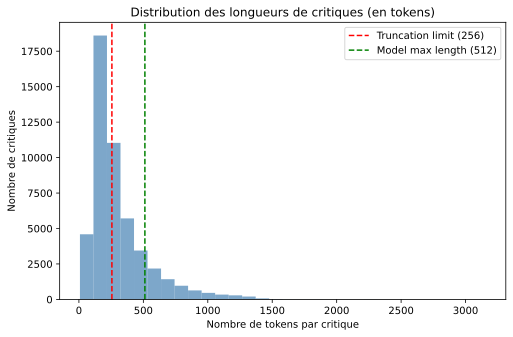

In [32]:
DistilBERT_study_dataset = LLMFineTuner()
DistilBERT_study_dataset.set_dataset()
DistilBERT_study_dataset.set_tokenizer()

df = pd.DataFrame(DistilBERT_study_dataset.dataset["train"])

total = len(df)
class_counts = df["sentiment"].value_counts()
print(f"Total samples: {total}")
print("Class counts:\n", class_counts)

# --- Calcul des longueurs en mots
df["word_count"] = df["review"].apply(lambda x: len(x.split()))

# --- Calcul de la longueur des tokens (réels, même > 512, sans erreur)
df["token_count_real"] = df["review"].apply(
    lambda x: len(DistilBERT_study_dataset.tokenizer.tokenize(x))
)

# --- Stats
avg_words = df["word_count"].mean()
med_words = df["word_count"].median()
avg_tokens = df["token_count_real"].mean()
med_tokens = df["token_count_real"].median()
print(f"\nNombre moyen de mots par critique: {avg_words:.1f} (mediane: {med_words})")
print(f"Nombre moyen de tokens par critique: {avg_tokens:.1f} (mediane: {med_tokens})")
# Nombre de critiques <= 256 tokens
below_256 = (df["token_count_real"] <= 256).sum()

# Pourcentage
pct_below_256 = below_256 / len(df) * 100

print(f"Nombre de critiques <= 256 tokens : {below_256}")
print(f"Pourcentage : {pct_below_256:.2f}%")

# --- Histogramme de la longueur des reviews (tokens)
plt.figure(figsize=(8, 5))
plt.hist(df["token_count_real"], bins=30, color="steelblue", alpha=0.7)
plt.axvline(256, color="red", linestyle="--", label="Truncation limit (256)")
plt.axvline(512, color="green", linestyle="--", label="Model max length (512)")
plt.xlabel("Nombre de tokens par critique")
plt.ylabel("Nombre de critiques")
plt.title("Distribution des longueurs de critiques (en tokens)")
plt.legend()
plt.show()

### Répartition des classes dans le dataset d'entraînement

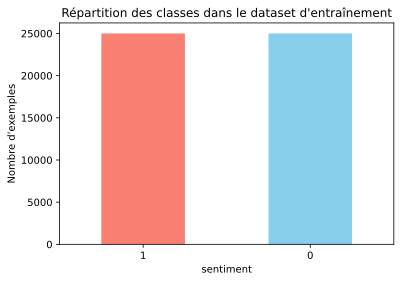

In [33]:
# --- Bar plot de la répartition des classes
plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("Répartition des classes dans le dataset d'entraînement")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=0)
plt.show()

### Part des critiques dépassant les limites de *tokens* (256 et 512)

In [34]:
lengths = []
for text in tqdm(
    DistilBERT_study_dataset.dataset["train"]["review"]
):  # 'dataset' is our raw dataset before mapping
    tokens = DistilBERT_study_dataset.tokenizer.encode(
        text, add_special_tokens=True
    )
    lengths.append(len(tokens))

lengths = np.array(lengths)
pct_over_256 = np.mean(lengths > 256) * 100
pct_over_512 = np.mean(lengths > 512) * 100

print(f"Reviews > 256 tokens: {pct_over_256:.2f}%")
print(f"Reviews > 512 tokens: {pct_over_512:.2f}%")

  0%|          | 0/50000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


Reviews > 256 tokens: 43.81%
Reviews > 512 tokens: 14.43%


## Worflow

### Création d'une instance de classe `LLMFineTuner`

In [35]:
DistilBERT_256 = LLMFineTuner()

### Téléchargement du jeu de données

In [36]:
DistilBERT_256.set_dataset()

### Préparation des entrées du modèle

In [37]:
DistilBERT_256.set_tokenizer()

### *Pre-processing* des données

In [38]:
DistilBERT_256.split_dataset()

In [44]:
# Récupérer les indices pour réutilisation
split_indices = {
    "train": list(range(len(DistilBERT_256.train_set))),
    "valid": list(range(len(DistilBERT_256.valid_set))),
}

In [45]:
DistilBERT_256.set_data_collator()

In [46]:
DistilBERT_256.set_loaders()

### Chargement du modèle

In [47]:
DistilBERT_256.set_model()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### *Optimizer* et *Scheduler*

In [48]:
DistilBERT_256.set_optimizer_and_scheduler()

### Entraînement


Epoch 1/5
  Perte d'entraînement: 0.5068
  Perte validation: 0.4543 | Precision: 0.8575
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_256-best

Epoch 2/5
  Perte d'entraînement: 0.2652
  Perte validation: 0.5803 | Precision: 0.8700

Epoch 3/5
  Perte d'entraînement: 0.1279
  Perte validation: 0.5911 | Precision: 0.8750

Epoch 4/5
  Perte d'entraînement: 0.0936
  Perte validation: 0.5911 | Precision: 0.8750

Epoch 5/5
  Perte d'entraînement: 0.0995
  Perte validation: 0.5911 | Precision: 0.8750


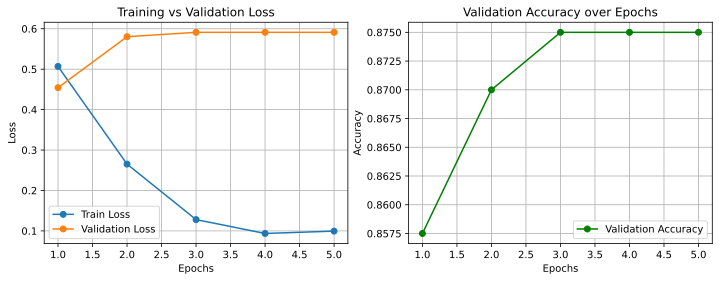

In [49]:
DistilBERT_256.train_and_validate(save_dir="./DistilBERT_256-best")
DistilBERT_256.plot_history()

### Tests de validité

#### Vérification des dimensions d'un batch

In [50]:
# Vérification des dimensions + tokens décodés
DistilBERT.sanity_check_batch(split="train", n=0)

=== Vérification d’un batch ===
Taille des Input IDs : torch.Size([4, 256])
Taille du Attention mask : torch.Size([4, 256])
Taille des Labels : torch.Size([4])

Exemple 0 du batch :
  input_ids : [101, 1045, 2253, 2000, 2023, 3185, 2012, 1037, 3459, 1998, 3626, 2265, 3426, 2026, 2767, 1010, 3183, 2003, 1037, 3135, 2006, 1996, 3185, 4778, 2033, 1012, 5293, 2054, 2017, 2031, 2464, 1999, 1996, 12698, 1010, 5293, 2054, 2017, 2031, 2657, 1010, 2175, 2156, 2023, 2143, 2005, 4426, 1012, 1045, 2001, 2062, 2084, 4527, 2011, 2009, 1012, 1999, 1037, 2088, 1997, 1996, 5861, 2818, 1010, 4918, 2015, 7048, 1010, 1996, 5351, 2154, 1010, 4895, 23890, 3085, 1010, 2182, 3310, 1037, 2143, 2008, 2003, 4276, 2115, 2524, 3687, 14189, 999, 14013, 5019, 1010, 6919, 25022, 25832, 13181, 21281, 1998, 1037, 3459, 2017, 2215, 2000, 4521, 2007, 2115, 2540, 1012, 1045, 2179, 2023, 2000, 2022, 2028, 1997, 2023, 2086, 2087, 23339, 24006, 3152, 1998, 2007, 3114, 1012, 2728, 7939, 9711, 17210, 2019, 7436, 7293, 1012, 20

#### Vérification des tokens spéciaux `[CLS]` et `[SEP]`

In [51]:
DistilBERT.sanity_check_special_tokens(split="train", n=0)

Tokens spéciaux [CLS] et [SEP] présents dans la séquence 0.


#### Vérification de la proportion de *padding* et troncation

In [52]:
DistilBERT.trunc_pad_stats(split="train", max_len=256)
DistilBERT.trunc_pad_stats(split="valid", max_len=256)

Statistiques sur train : {'total_examples': 1600, 'padded_frac': 0.53, 'truncated_frac': 0.4425, 'exact_len_frac': 0.4425}
Statistiques sur valid : {'total_examples': 400, 'padded_frac': 0.5325, 'truncated_frac': 0.44, 'exact_len_frac': 0.44}


{'total_examples': 400,
 'padded_frac': 0.5325,
 'truncated_frac': 0.44,
 'exact_len_frac': 0.44}

#### Affichage d'un exemple paddé

In [53]:
DistilBERT.show_padded_example(split="train", n_last_tokens=30)

...fin des tokens : ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
...fin du masque : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Inférence

#### Chargement du meilleur modèle associé à *DistilBERT*

In [55]:
DistilBERT_best = LLMFineTuner()
DistilBERT_best.load_best_model("./DistilBERT_256-best")

Modèle et tokenizer rechargés depuis ./DistilBERT_256-best


#### Inférence sur deux *reviews*

In [56]:
print(
    json.dumps(
        DistilBERT_best.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        DistilBERT_best.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.015198367647826672,
        "positive": 0.9848015904426575
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9890297055244446,
        "positive": 0.010970271192491055
    }
}


#### Inférence sur un *batch* de *reviews*

In [57]:
reviews = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was decent but the story was too slow.",
    "What a masterpiece - I'd watch it again and again!",
]

batch_results = DistilBERT_best.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.015198367647826672,
        "positive": 0.9848015904426575
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9890297055244446,
        "positive": 0.010970271192491055
    }
}
{
    "text": "The acting was decent but the story was too slow.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9854192733764648,
        "positive": 0.014580762013792992
    }
}
{
    "text": "What a masterpiece - I'd watch it again and again!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.04608204960823059,
        "positive": 0.9539179801940918
    }
}


####

## Choix d'un nouveau modèle : `RoBERTa`

Démarrage du workflow d'entraînement...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 1/5
  Perte d'entraînement: 0.5556
  Perte validation: 0.1841 | Precision: 0.9450
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 2/5
  Perte d'entraînement: 0.2883
  Perte validation: 0.0701 | Precision: 0.9875
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 3/5
  Perte d'entraînement: 0.1164
  Perte validation: 0.0606 | Precision: 0.9875
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 4/5
  Perte d'entraînement: 0.0788
  Perte validation: 0.0606 | Precision: 0.9875

Epoch 5/5
  Perte d'entraînement: 0.0735
  Perte validation: 0.0606 | Precision: 0.9875


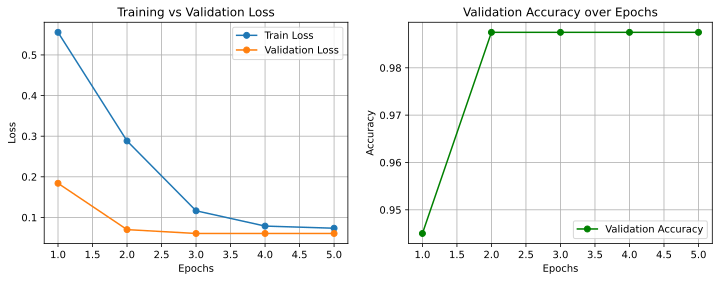

In [58]:
model_name = "roberta-base"
RoBERTa_256 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path=model_name,
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_256.workflow(
    mode="train",
    split_dataset_kwargs={"split_indices": split_indices, "n_samples": 2000},
    #set_optimizer_and_scheduler_kwargs={"learning_rate": 2e-5},
    train_and_validate_kwargs={"save_dir": "./RoBERTa_256-best"},
)
RoBERTa_256.plot_history()

### Inférence

#### Chargement du meilleur modèle associé à `RoBERTa`

In [59]:
RoBERTa_256_best = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa-256-best",
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_256_best.load_best_model("./RoBERTa_256-best")

Modèle et tokenizer rechargés depuis ./RoBERTa_256-best


#### Inférence sur un *batch* de *reviews*

In [60]:
batch_results = RoBERTa_256_best.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.00036188866943120956,
        "positive": 0.9996380805969238
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9993940591812134,
        "positive": 0.0006058761500753462
    }
}
{
    "text": "The acting was decent but the story was too slow.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9986124038696289,
        "positive": 0.0013876304728910327
    }
}
{
    "text": "What a masterpiece - I'd watch it again and again!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.0003975295985583216,
        "positive": 0.9996024966239929
    }
}


## Comparaison entre les meilleurs modèles obtenus pour `DistilBert` et `RoBERTa`

In [61]:
DistilBERT_best.set_dataset()
DistilBERT_best.set_tokenizer()
DistilBERT_best.split_dataset()
DistilBERT_best.set_data_collator()
DistilBERT_best.set_loaders()

RoBERTa_256_best.set_dataset()
RoBERTa_256_best.set_tokenizer()
RoBERTa_256_best.split_dataset()
RoBERTa_256_best.set_data_collator()
RoBERTa_256_best.set_loaders()

res = DistilBERT_best.compare(RoBERTa_256_best)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


=== Comparaison des métriques ===
accuracy             | self=0.8575 | other=0.9750 | diff=-0.1175 → pire
f1_score             | self=0.8403 | other=0.9731 | diff=-0.1328 → pire
confusion_matrix     :
  self = [[193, 22], [35, 150]]
  other = [[209, 6], [4, 181]]
  → self fait plus de FAUX NÉGATIFS (35) que de FAUX POSITIFS (22)
  → other fait plus de FAUX POSITIFS (6) que de FAUX NÉGATIFS (4)
classification_report : voir dictionnaire


## Effet de la longueur maximale de séquence sur la couverture des critiques (256 vs 512 *tokens*)

Démarrage du workflow d'entraînement...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
  Perte d'entraînement: 0.5024
  Perte validation: 0.5671 | Precision: 0.8525
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_512-best

Epoch 2/5
  Perte d'entraînement: 0.2793
  Perte validation: 0.6214 | Precision: 0.8500

Epoch 3/5
  Perte d'entraînement: 0.1283
  Perte validation: 0.6162 | Precision: 0.8700

Epoch 4/5
  Perte d'entraînement: 0.0649
  Perte validation: 0.6162 | Precision: 0.8700

Epoch 5/5
  Perte d'entraînement: 0.0776
  Perte validation: 0.6162 | Precision: 0.8700


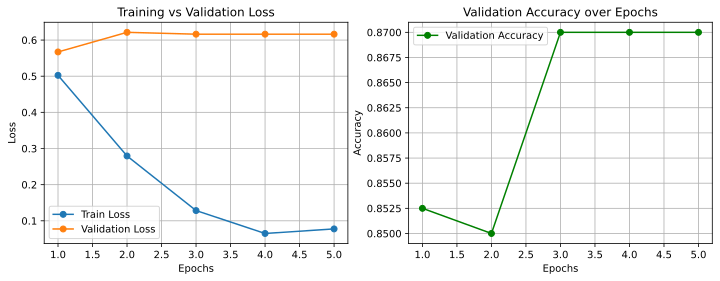

In [62]:
DistilBERT_512 = LLMFineTuner(
    pretrained_model_name_or_path="distilbert-base-uncased",
)
DistilBERT_512.workflow(
    mode="train",
    split_dataset_kwargs={"max_length": 512},
    train_and_validate_kwargs={"save_dir": "./DistilBERT_512-best"},
)
DistilBERT_512.plot_history()

Démarrage du workflow d'entraînement...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 1/5
  Perte d'entraînement: 0.5139
  Perte validation: 0.4306 | Precision: 0.9100
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_512-best

Epoch 2/5
  Perte d'entraînement: 0.2659
  Perte validation: 0.4437 | Precision: 0.8975

Epoch 3/5
  Perte d'entraînement: 0.1036
  Perte validation: 0.4606 | Precision: 0.9200

Epoch 4/5
  Perte d'entraînement: 0.0612
  Perte validation: 0.4606 | Precision: 0.9200

Epoch 5/5
  Perte d'entraînement: 0.0652
  Perte validation: 0.4606 | Precision: 0.9200


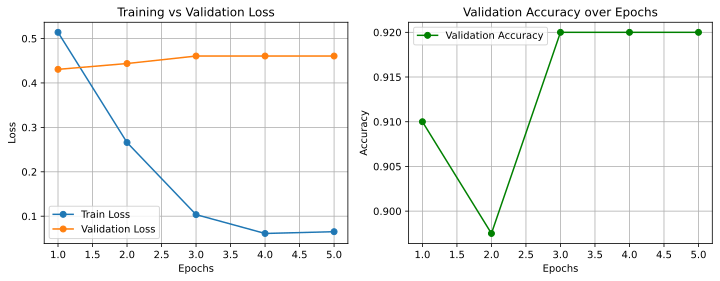

In [63]:
RoBERTa_512 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="roberta-base",
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_512.workflow(
    mode="train",
    split_dataset_kwargs={"max_length": 512},
    train_and_validate_kwargs={"save_dir": "./RoBERTa_512-best"},
)
RoBERTa_512.plot_history()

## Utilisation d'un nouveau jeu de données

In [66]:
rt = load_dataset("rotten_tomatoes")
MAX_LEN = 256
BATCH = 16

# 1) Évaluations IMDB avec evaluate()
distil_256 = LLMFineTuner(
    model_cls=DistilBertForSequenceClassification,
    pretrained_model_name_or_path="./DistilBERT_256-best",
    tokenizer_cls=DistilBertTokenizer,
)
res_distil_256_imdb = distil_256.workflow(mode="evaluation")

distil_512 = LLMFineTuner(
    model_cls=DistilBertForSequenceClassification,
    pretrained_model_name_or_path="./DistilBERT_512-best",
    tokenizer_cls=DistilBertTokenizer,
)
res_distil_512_imdb = distil_512.workflow(mode="evaluation")

roberta_256 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa_256-best",
    tokenizer_cls=AutoTokenizer,
)
res_r256_imdb = roberta_256.workflow(mode="evaluation")

roberta_512 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa_512-best",
    tokenizer_cls=AutoTokenizer,
)
res_r512_imdb = roberta_512.workflow(mode="evaluation")

Démarrage du workflow d'évaluation...
Démarrage du workflow d'évaluation...
Démarrage du workflow d'évaluation...


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Démarrage du workflow d'évaluation...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# 2) Évaluations Rotten Tomatoes (zero-shot)
res_distil_256_rt = distil_256.zero_shot_evaluate(
    "./DistilBERT_256-best",
    rt["validation"],
    max_len=256,
    batch_size=BATCH,
    verbose=False,
)

res_distil_512_rt = distil_512.zero_shot_evaluate(
    "./DistilBERT_512-best",
    rt["validation"],
    max_len=512,
    batch_size=BATCH,
    verbose=False,
)

res_r256_rt = roberta_256.zero_shot_evaluate(
    "./RoBERTa_256-best",
    rt["validation"],
    max_len=256,
    batch_size=BATCH,
    verbose=False,
)

res_r512_rt = roberta_512.zero_shot_evaluate(
    "./RoBERTa_512-best",
    rt["validation"],
    max_len=512,
    batch_size=BATCH,
    verbose=False,
)

# 3) Extraire les macro-F1
models = ["DistilBERT-256", "DistilBERT-512", "RoBERTa-256", "RoBERTa-512"]
f1_imdb = [
    res_distil_256_imdb["f1_score"],
    res_distil_512_imdb["f1_score"],
    res_r256_imdb["f1_score"],
    res_r512_imdb["f1_score"],
]
f1_rt = [
    res_distil_256_rt["macro_f1"],
    res_distil_512_rt["macro_f1"],
    res_r256_rt["macro_f1"],
    res_r512_rt["macro_f1"],
]

# 4) Visualisation
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(
    x - width / 2, f1_imdb, width, label="IMDB (in-domain)", color="steelblue"
)
bars2 = ax.bar(
    x + width / 2,
    f1_rt,
    width,
    label="Rotten Tomatoes (zero-shot)",
    color="orange",
)

ax.set_ylabel("Macro F1 Score")
ax.set_title("Macro-F1 Comparison: IMDB vs Rotten Tomatoes (Zero-Shot)")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0.7, 1.0)
ax.legend()

# Annoter les barres avec les valeurs
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()